### 1. Реализовать персональный топ  - принимает на вход возраст и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 27) - 3 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Совстречаемость - 3 балла

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок.

### 4. Коллаборативная фильтрация - 3 балла

Коллаборативную фильтрацию реализовывать как на слайде 51 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл. Реализовать U2I и I2I рекомендации.

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации

Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)

Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.

In [3]:
!pip3 install lightfm

     |████████████████████████████████| 310 kB 5.3 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705370 sha256=dac8d927bbfe1f3488cf0421a2f056f42800b927d2c30a2157ff14cdfe7029b5
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [4]:
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM

In [5]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Отображение данных
-need-fix-

# Выполнение заданий

In [6]:
books = pd.read_csv("https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture09/HW/BX-Books.csv")
interactions = pd.read_csv("https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture09/HW/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")
users = pd.read_csv('https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture09/HW/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
interactions.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
interactions = interactions[interactions["Book-Rating"] != 0]

In [10]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [11]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [12]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [13]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [14]:
interactions

,User-ID,ISBN,Book-Rating,user_num,books_num
5,86583,3404139178,9,8,18
6,86583,3453061187,8,13,18
13,86583,3426609061,7,8,18
8555,16877,038550120X,9,81,10
8556,16877,034539657X,7,26,10
...,...,...,...,...,...
412270,108487,1573220183,10,6,11
412271,108487,1571312471,10,6,11
412736,250227,0380795272,8,8,9
420027,205839,0312971842,8,8,6


In [15]:
users = users.loc[:, ["Location", "Age"]]
users = users[~users["Age"].isna()]
users = users["Location"].apply(lambda str: str.replace(",", ""))
users

1                  stockton california usa
3                  porto v.n.gaia portugal
5              santa monica california usa
9                 albacete wisconsin spain
10            melbourne victoria australia
                        ...               
278848           georgetown ontario canada
278850                    dallas texas usa
278851       brisbane queensland australia
278852        stranraer n/a united kingdom
278854    tacoma washington united kingdom
Name: Location, Length: 168096, dtype: object

In [16]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [17]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [18]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

In [19]:
for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
    if "David Copperfield" in j:
        print("idx:", i, "\tBook Title:", j)

idx: 10174 	Book Title: David Copperfield (Wordsworth Classics)
idx: 1074 	Book Title: David Copperfield (Penguin Classics)


In [20]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

## (1) Кластеризация 

In [21]:
class Top():
    def __init__(self, Int):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
    

    def top_items(self):
        # Хотим получить в отсортированном порядке датафрейм - product_id, user_number
        items = self.interactions\
                    .groupby("product_id")["Book-Rating"].mean() \
                    .reset_index() \
                    .sort_values("Book-Rating", ascending=False)[:10]
        
        rec_imaging(items["product_id"].values, self.product_id_to_url, items["Book-Rating"].values)

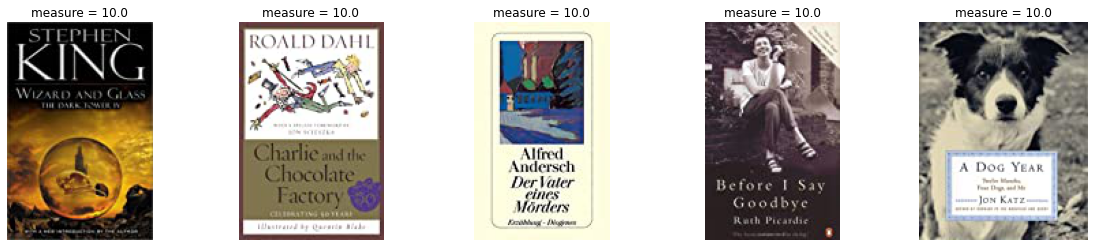

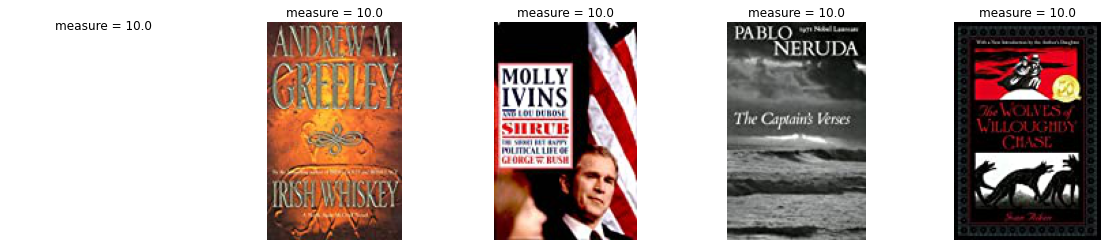

In [22]:
T = Top(interactions)
T.top_items()

# (2) Совстречаемость

In [23]:
interactions.head()

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,3445
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,5248
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,2622
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,10887
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10397,4228


In [42]:
class Recomendations():
    def __init__(self, Int):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id"]].drop_duplicates()
        # Для каждого пользователя собираем товары, с которыми он взамиодействовал
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        # Считаем число товаров, с которыми взаимодействовал каждый пользователь и записываем в колонку prod_num
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        # Фильтруем пользователей, взаимодействовавших с одним товаром
        user_products = user_products[user_products["prod_num"] > 1]
        
        # Заводим словарь под товары
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += (i[1][j] + i[1][k] / 2) 
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            # Если товары встетились вместе больше одного раза, то добавляем в список
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [43]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10012 [00:00<?, ?it/s]

In [44]:
cooc_rec.cooc_rec.sort_values("measure", ascending=False).head()

,item1,item2,measure
189,7035,4216,566867.0
17576,7036,4217,502948.5
192,7035,4224,484792.0
9029,9430,9425,480846.0
9018,9425,9430,480761.0


Для товара


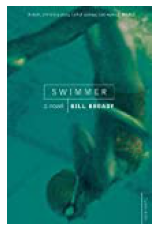

Такие рекомендации


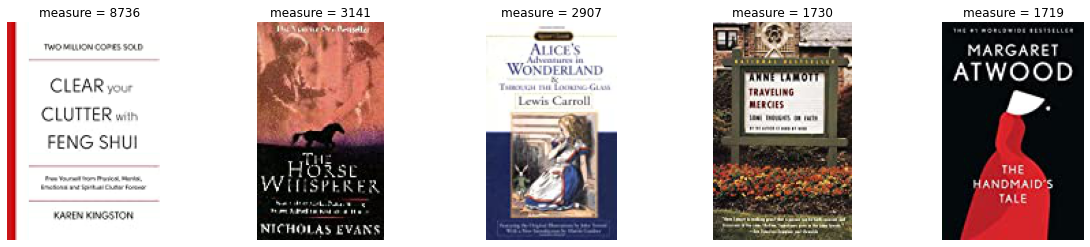

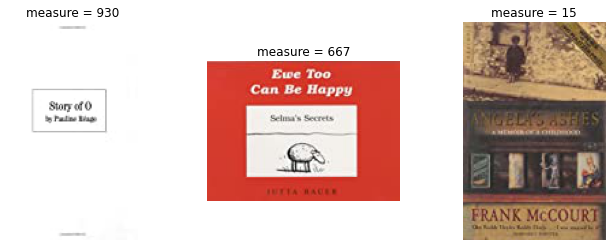

In [45]:
cooc_rec.get_rec(11)